# Import statements

In [1]:
%run "ZeroMQ Python Connector".py
%load_ext autoreload
%autoreload
%matplotlib notebook
import pandas as pd
from functools import partial

# Initialisation and Testing

In [2]:
#Create connector instance, with particular port for PUSH, PULL and SUB
connector = DWX_ZeroMQ_Connector()

[INIT] Ready to send commands to METATRADER (PUSH): 32768
[INIT] Listening for responses from METATRADER (PULL): 32769
[INIT] Listening for market data from METATRADER (SUB): 32770


In [4]:
ID = connector._DWX_MTX_SEND_RATESDATA_REQUEST_(_symbol='GBPUSD', _start=(Timestamp.now()-Timedelta(days=20)).strftime('%Y.%m.%d %H:%M:00'), _timeframe=1440, _end=Timestamp.now().strftime('%Y.%m.%d %H:%M:00'))
response = connector._get_response_(messageID=ID)
print("\n This is the response: ", response)

{'_messageID': 1515294092, '_action': 'DATA', '_data': {'2019.05.10 00:00': [1.29977, 1.30471, 1.2991, 1.29999, 129086, 0, 0], '2019.05.13 00:00': [1.29992, 1.30407, 1.2941, 1.29566, 113113, 0, 0], '2019.05.14 00:00': [1.29533, 1.297, 1.2903, 1.29031, 106690, 0, 0], '2019.05.15 00:00': [1.29053, 1.29231, 1.28262, 1.28419, 115960, 0, 0], '2019.05.16 00:00': [1.28419, 1.28517, 1.27876, 1.27937, 94823, 0, 0], '2019.05.17 00:00': [1.27913, 1.2798, 1.27143, 1.27158, 100720, 0, 0], '2019.05.20 00:00': [1.27346, 1.27571, 1.27147, 1.27218, 82458, 0, 0], '2019.05.21 00:00': [1.27196, 1.28137, 1.26853, 1.27009, 115251, 0, 0], '2019.05.22 00:00': [1.27076, 1.27191, 1.26241, 1.26599, 108020, 0, 0], '2019.05.23 00:00': [1.26463, 1.26838, 1.26051, 1.26565, 116250, 0, 0], '2019.05.24 00:00': [1.26542, 1.27332, 1.26472, 1.27113, 106477, 0, 0], '2019.05.27 00:00': [1.27221, 1.27477, 1.26672, 1.26756, 93952, 0, 0], '2019.05.28 00:00': [1.26764, 1.27016, 1.26505, 1.26523, 116677, 0, 0], '2019.05.29 00:00

# Order Testing

In [ ]:
response = Series(connector._get_response_())
responseData = Series(response["_data"])
print(type(responseData[0]))
order = connector._generate_default_order_dict()
print(order)

In [ ]:
order = connector._generate_default_order_dict()
connector._DWX_MTX_SEND_MARKETDATA_REQUEST_(_symbol='GBPUSD', _start=(Timestamp.now()-Timedelta(minutes=1)).strftime('%Y.%m.%d %H:%M:00'),_timeframe=1,_end=Timestamp.now().strftime('%Y.%m.%d %H:%M:00'))
response = Series(connector._get_response_())
responseData = Series(response["_data"])
order['_symbol'] = 'GBPUSD'
order['_price'] = responseData[0]
#connector._DWX_MTX_NEW_TRADE_(order)

In [ ]:
message = connector._DWX_MTX_GET_ALL_OPEN_TRADES_()
print(message)

# Obtaining Market Data Chunks

In [8]:
def obtainMarketDataChunk(symbol,startTime, endTime, timeframe=1, data='DATA', chunkSize = 125):
    
    ## Required Variables 
    outputFrame = pd.DataFrame() # dataframe that will be returned
    chunkTime = timeframe * chunkSize # Time in minutes of 1 chunk. 
    pdStartTime = Timestamp.strptime(startTime,'%Y.%m.%d %H:%M:00') # Start time as Panda's datetime object
    pdEndTime = Timestamp.strptime(endTime,'%Y.%m.%d %H:%M:00') # End time as Panda's datetime object
    timeDelta = pdEndTime - pdStartTime # Difference in two times
    divMod = divmod(timeDelta,Timedelta(minutes=chunkTime)) # Number of chunks required
    currentStartTime = pdStartTime
    currentEndTime = pdEndTime
    response = None
    
    if data == 'RATESDATA':
        requestDataFunction = partial(connector._DWX_MTX_SEND_RATESDATA_REQUEST_,_symbol=symbol, _timeframe=timeframe)
    elif data == 'DATA':
        requestDataFunction = partial(connector._DWX_MTX_SEND_MARKETDATA_REQUEST_,_symbol=symbol, _timeframe=timeframe)
    
    print(divMod) # For testing
    
    for x in range(divMod[0]):
        print("--------------------------------------------------------------------------------------------------")
        oldResponse = connector._get_response_()
        currentEndTime = pdStartTime + (x+1)*Timedelta(minutes=(chunkTime))
        print(currentStartTime.strftime('%Y.%m.%d %H:%M:00'))
        print(currentEndTime.strftime('%Y.%m.%d %H:%M:00'))
        ID = requestDataFunction(_start=currentStartTime.strftime('%Y.%m.%d %H:%M:00')
                                 ,_end=currentEndTime.strftime('%Y.%m.%d %H:%M:00'))
        
        response = connector._get_response_(messageID = ID, maximumTime=8)
        outputFrame = outputFrame.append(pd.DataFrame.from_dict(response['_data'],orient='index')) # Append to dataframe
        currentStartTime = currentEndTime
        sleep(0.1) # To prevent resource timeout
        print("--------------------------------------------------------------------------------------------------")
        
    
    print("--------------------------------------------------------------------------------------------------")
    ID = requestDataFunction(_start=currentStartTime.strftime('%Y.%m.%d %H:%M:00'),_end=endTime)
    print(currentStartTime.strftime('%Y.%m.%d %H:%M:00'))
    print(endTime)
    response = connector._get_response_(messageID = ID, maximumTime = 8)
    outputFrame = outputFrame.append(pd.DataFrame.from_dict(response['_data'],orient='index'))
    outputFrame = outputFrame.reset_index()
    if data == 'DATA':
        outputFrame.rename(columns={'index':'Date', 0:'Close'}, inplace=True)
    elif data == 'RATESDATA':
        outputFrame.rename(columns={'index':'Date', 0:'Open', 1:'High', 2:'Low', 3:'Close', 4:'TickVol', 5:'Spread', 6:'RealVol'}, inplace=True)
    outputFrame['Date'] = pd.to_datetime(outputFrame['Date'], format='%Y.%m.%d %H:%M')
    outputFrame = outputFrame.set_index('Date')
    print("--------------------------------------------------------------------------------------------------")
    return outputFrame


# Testing Market Data Chunk Retrieval

In [12]:
datachunk = obtainMarketDataChunk('GBPUSD', '2017.05.27 00:00:00', '2019.05.28 00:00:00',timeframe=1440, data='RATESDATA')
print(datachunk.to_string())

(5, Timedelta('106 days 00:00:00'))
--------------------------------------------------------------------------------------------------
2017.05.27 00:00:00
2017.09.29 00:00:00
{'_messageID': 337205218, '_action': 'DATA', '_data': {'2017.05.29 00:00': [1.27988, 1.28505, 1.27988, 1.28391, 151313, 0, 0], '2017.05.30 00:00': [1.28393, 1.28882, 1.27939, 1.2857, 128939, 0, 0], '2017.05.31 00:00': [1.28575, 1.2921, 1.27691, 1.28883, 135722, 0, 0], '2017.06.01 00:00': [1.28901, 1.29154, 1.28299, 1.28805, 122013, 0, 0], '2017.06.02 00:00': [1.28801, 1.29036, 1.28458, 1.28908, 133170, 0, 0], '2017.06.05 00:00': [1.28566, 1.29407, 1.28566, 1.29039, 99331, 0, 0], '2017.06.06 00:00': [1.29031, 1.29497, 1.28722, 1.2906, 128483, 0, 0], '2017.06.07 00:00': [1.2906, 1.29687, 1.28876, 1.29564, 140475, 0, 0], '2017.06.08 00:00': [1.29514, 1.29775, 1.2908, 1.29484, 141141, 0, 0], '2017.06.09 00:00': [1.28058, 1.28379, 1.26353, 1.27431, 225771, 0, 0], '2017.06.12 00:00': [1.27199, 1.27694, 1.26386, 1.26571,

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
2018.02.01 00:00:00
2018.06.06 00:00:00
{'_messageID': 1221192703, '_action': 'DATA', '_data': {'2018.02.01 00:00': [1.41698, 1.4278, 1.41593, 1.42595, 206435, 0, 0], '2018.02.02 00:00': [1.42506, 1.42779, 1.41016, 1.41163, 219356, 0, 0], '2018.02.05 00:00': [1.4104, 1.41505, 1.39546, 1.39573, 222516, 0, 0], '2018.02.06 00:00': [1.39572, 1.39993, 1.38362, 1.39474, 277720, 0, 0], '2018.02.07 00:00': [1.39461, 1.39938, 1.38484, 1.38794, 201519, 0, 0], '2018.02.08 00:00': [1.3874, 1.40669, 1.38455, 1.39103, 250337, 0, 0], '2018.02.09 00:00': [1.39099, 1.39873, 1.37645, 1.38276, 244558, 0, 0], '2018.02.12 00:00': [1.38066, 1.38757, 1.37958, 1.38338, 167799, 0, 0], '2018.02.13 00:00': [1.38356, 1.39243, 1.38322, 1.3891, 170682, 0, 0], '2018.02.14 00:00': [1.38872, 1.40165, 1.38, 1.39978, 210533, 

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
2019.02.11 00:00:00
2019.05.28 00:00:00
{'_messageID': 1137434166, '_action': 'DATA', '_data': {'2019.02.11 00:00': [1.29277, 1.2939, 1.28449, 1.28592, 115630, 0, 0], '2019.02.12 00:00': [1.28523, 1.29094, 1.28328, 1.28899, 116243, 0, 0], '2019.02.13 00:00': [1.2891, 1.29583, 1.28448, 1.28448, 126168, 0, 0], '2019.02.14 00:00': [1.28456, 1.28776, 1.27729, 1.27982, 132336, 0, 0], '2019.02.15 00:00': [1.27967, 1.28983, 1.27846, 1.28882, 120356, 0, 0], '2019.02.18 00:00': [1.29041, 1.29387, 1.28916, 1.29223, 114717, 0, 0], '2019.02.19 00:00': [1.29176, 1.3073, 1.28956, 1.30609, 120573, 0, 0], '2019.02.20 00:00': [1.30602, 1.3109, 1.30117, 1.30488, 126974, 0, 0], '2019.02.21 00:00': [1.30461, 1.30951, 1.3026, 1.30371, 135619, 0, 0], '2019.02.22 00:00': [1.30248, 1.308, 1.29679, 1.3054, 127336, 0

In [15]:
#datachunk.loc['2019-05-27 00:00:00':,'Open':'Close']
datachunk.loc['2019-05-27 00:00:00':,:]

,Open,High,Low,Close,TickVol,Spread,RealVol
Date,,,,,,,
2019-05-27,1.27221,1.27477,1.26672,1.26756,93952,0,0
2019-05-28,1.26764,1.27016,1.26505,1.26523,116677,0,0


<IPython.core.display.Javascript object>


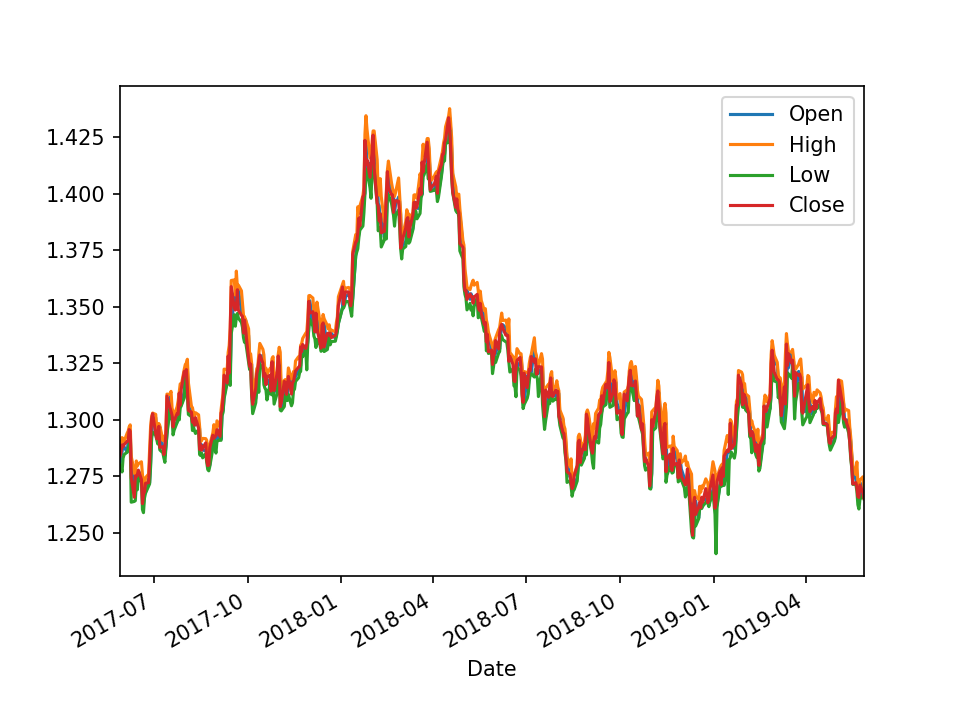

In [16]:
datachunk.loc[:,'Open':'Close'].plot()